ResNet-type Skip connection blocks\
author: rahul deshmukh\
email: deshmuk5@purdue.edu

Sources:
1. https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035\
2. https://arxiv.org/pdf/1512.03385.pdf
3. http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006
4. https://engineering.purdue.edu/kak/distDLS/DLStudio-1.0.4.html



In [1]:
import csv,os
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, transform

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchsummary import summary

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## (1) Network definition

In [0]:
class BottleNeck_Block(nn.Module):
  """ 3-conv layer bottleneck block"""
  def __init__(self,in_channels,mid_channels,out_channels, downsample=False, skip_connections=True):
    super().__init__()
    self.in_channels = in_channels
    self.mid_channels = mid_channels
    self.out_channels = out_channels
    self.downsample = downsample
    self.skip_connections = skip_connections

    norm_layer = nn.BatchNorm2d
    self.bn_in = norm_layer(in_channels)
    self.bn_mid = norm_layer(mid_channels)
    self.bn_out = norm_layer(out_channels)    
    if downsample:
      self.conv1 = nn.Conv2d(in_channels, mid_channels, 1, stride=2)
      self.downsampler = nn.Conv2d(in_channels,in_channels, 1, stride=2)
    else:
      self.conv1 = nn.Conv2d(in_channels, mid_channels, 1)
      # self.downsampler = nn.Conv2d(in_channels,out_channels, 1)
    self.conv2 = nn.Conv2d(mid_channels,mid_channels,3,padding=1)
    self.conv3 = nn.Conv2d(mid_channels,out_channels, 1)    


  def forward(self,x):
    identity = x.clone()
    # first conv layer
    out = self.conv1(x)
    out = self.bn_mid(out)
    out = F.relu(out)
    # second conv layer
    out = self.conv2(out)
    out = self.bn_mid(out)
    out = F.relu(out)
    # third conv layer
    out = self.conv3(out)
    out = self.bn_out(out)
    if self.downsample:
      identity = self.downsampler(identity)
      identity = self.bn_in(identity)
    # elif self.in_channels != self.out_channels: 
    #   identity = self.downsampler(identity)
    #   identity = self.bn_out(identity)
      
    if self.skip_connections:
      if self.in_channels == self.out_channels:
          out += identity                              
      else:
        for num in range(self.out_channels//self.in_channels):
          out[:,num*self.in_channels:(num+1)*self.in_channels,:,:] += identity
        # out += identity
    return(F.relu(out))

class ResNet_BottleNeck(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.config = config
    self.conv = nn.Conv2d(3,64,7,stride=2,padding=3) 
    self.pool = nn.MaxPool2d(3,stride=2, padding=1)
    
    # self.btlnck_blk_64_256_ds = BottleNeck_Block(64,64,256,downsample=True)
    self.btlnck_blk_64_256 = BottleNeck_Block(64,64,256)
    self.btlnck_blk256 = BottleNeck_Block(256,64,256)

    self.btlnck_blk_256_512_ds = BottleNeck_Block(256,128,512,downsample=True)
    self.btlnck_blk512 = BottleNeck_Block(512,128,512)

    self.btlnck_blk_512_1024_ds = BottleNeck_Block(512,256,1024,downsample=True)
    self.btlnck_blk1024 = BottleNeck_Block(1024,256,1024)

    self.btlnck_blk_1024_2048_ds = BottleNeck_Block(1024,512,2048,downsample=True)
    self.btlnck_blk2048 = BottleNeck_Block(2048,512,2048)

    self.av_pool = nn.AvgPool2d(7,1)
    self.fc1 =  nn.Linear(2048, 5)

  def forward(self,x):
    x = self.pool(F.relu(self.conv(x)))
    x = self.btlnck_blk_64_256(x)
    for _ in range(self.config[0]-1):
      x = self.btlnck_blk256(x)                                               
    x = self.btlnck_blk_256_512_ds(x)
    for _ in range(self.config[1]-1):
      x = self.btlnck_blk512(x)                                               
    x = self.btlnck_blk_512_1024_ds(x)
    for _ in range(self.config[2]-1):
      x = self.btlnck_blk1024(x)
    x = self.btlnck_blk_1024_2048_ds(x)
    for _ in range(self.config[3]-1):
      x = self.btlnck_blk2048(x)
    x = self.av_pool(x)
    x = x.view(-1, 2048)
    x = self.fc1(x)
    return x 

class ResNet50(ResNet_BottleNeck):
  config = np.array([3,4,6,3]) 
  def __init__(self, config=config):
    super().__init__(config)

class ResNet101(ResNet_BottleNeck):
  config = np.array([3,4,23,3]) 
  def __init__(self, config=config):
    super().__init__(config)

class ResNet152(ResNet_BottleNeck):
  config = np.array([3,8,36,3]) 
  def __init__(self, config=config):
    super().__init__(config)

def run_code_for_training(net,train_dataloader, epochs, device, datalen):
  net.to(device)
  criterion = nn.CrossEntropyLoss()
  #optimizer = torch.optim.SGD(net.parameters(), lr=1e-4, momentum=0.9)
  optimizer = torch.optim.Adam(net.parameters(),lr=1e-4)
  epoch_loss=[]
  for epoch in range(epochs):  
      print("\n")
      running_loss = 0.0
      running_epoch_loss=0.0
      for i, data in enumerate(train_dataloader):
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)
          optimizer.zero_grad()
          # Make the predictions with the model:
          outputs = net(inputs)

          loss = criterion(outputs, labels)

          loss.backward()
          optimizer.step()
          running_loss += loss.item()
          running_epoch_loss +=loss.item()
          if (i+1)%200 == 0:    
              avg_loss = running_loss / float(200)
              print("[epoch:%d, batch:%5d] batch avergaged loss: %.3f" % (epoch + 1, i + 1, avg_loss))
              running_loss = 0.0
      epoch_loss.append(running_epoch_loss/datalen)
      running_epoch_loss=0.0
  print("\nFinished Training\n")
  return(epoch_loss)

def run_code_for_testing(net, test_data_loader, device):
  accuracy=0
  count=0
  with torch.set_grad_enabled(False):
    net.eval()
    net.to(device)  
    for i,data in enumerate(test_data_loader):
      x, y_true = data
      x, y_true = x.to(device), y_true.to(device)
      y_pred = net(x)
      _, y_pred = torch.max(F.softmax(y_pred, dim=1), dim=1)
      for b in range(y_pred.shape[0]): 
        if y_true[b]==y_pred[b]: accuracy+=1
      count += y_pred.shape[0]
    accuracy = accuracy/count
  return accuracy*100

##(2) ImageNet experiment
### Foreword:
1. The data was downloaded using https://github.com/mf1024/ImageNet-Datasets-Downloader
2. imagenet5 folder contains 5 classes and a total of 5517 images
3. The data was partitioned into training and testing with 80:20 ratio. Such that each class follows this ratio
4. Samples for training and testing were drawn after shuffling the data in each class.





### Custom dataset for ImageNet



In [0]:
#%% ----------------- Class Definitions --------------------------------------#
class ImageNetDataset(Dataset):
  in_channels=3
  image_size = 224
  def __init__(self,root_dir, train=True, transform = None):
    self.root_dir = root_dir
    self.train = train
    self.transform = transform 
    if train: 
        self.csvfile = root_dir + 'train_data.csv'
    else: 
        self.csvfile = root_dir + 'test_data.csv'
    with open(self.csvfile,'rt') as f:
      reader = csv.reader(f,delimiter=',')
      self.data_list = [row for row in reader]

    self.normalize = torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

  def __len__(self):
    self.datalen = len(self.data_list)
    return(self.datalen)
      
  def __getitem__(self,idx):
    img_name = self.root_dir + self.data_list[idx][0]
    class_id =  int(self.data_list[idx][1])
    image = io.imread(img_name)/255        
    #resize image and mask
    image = transform.resize(image,(self.image_size, self.image_size, self.in_channels),
                              anti_aliasing=False)        
    # reshape from (H,W,C) -> (C,H,W)            
    image = image.transpose(2,0,1)
    image_tensor = torch.from_numpy(image.astype(np.float32))    
    image_tensor = self.normalize(image_tensor)
    # augmentation
    if self.transform is not None: image_tensor = self.transform(image_tensor)                 
    return(image_tensor, class_id)

### Create ImageNet dataloaders


In [0]:
root_dir = './gdrive/My Drive/ECE695_DL/HW4/imagenet5/'
save_dir = './gdrive/My Drive/ECE695_DL/HW4/'
batch_size = 4

train_dataset = ImageNetDataset(root_dir)
test_dataset = ImageNetDataset(root_dir, train=False)

train_dataloader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size, shuffle=False, num_workers=4)

### Print Network summary

In [0]:
net = ResNet101()
# summary(net, (3,224,224),-1,device='cpu')

### Train network

In [6]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

epochs=20

if os.path.exists(save_dir+'wts50.pkl'):
  net.load_state_dict(torch.load(save_dir+'wts50.pkl'))
  epoch_counter = int(np.load(save_dir+'epoch_counter.npy'))
else:
  epoch_counter = 0

train_loss= run_code_for_training(net, train_dataloader, epochs, device, train_dataset.datalen)
classification_accuracy= run_code_for_testing(net,test_dataloader,device)
# save wts and epochs
torch.save(net.state_dict(), save_dir + 'wts50.pkl')
np.save(save_dir+'epoch_counter.npy',epoch_counter+epochs)



[epoch:1, batch:  200] batch avergaged loss: 1.718
[epoch:1, batch:  400] batch avergaged loss: 1.548
[epoch:1, batch:  600] batch avergaged loss: 1.486
[epoch:1, batch:  800] batch avergaged loss: 1.403
[epoch:1, batch: 1000] batch avergaged loss: 1.430


[epoch:2, batch:  200] batch avergaged loss: 1.358
[epoch:2, batch:  400] batch avergaged loss: 1.363
[epoch:2, batch:  600] batch avergaged loss: 1.282
[epoch:2, batch:  800] batch avergaged loss: 1.293
[epoch:2, batch: 1000] batch avergaged loss: 1.304


[epoch:3, batch:  200] batch avergaged loss: 1.225
[epoch:3, batch:  400] batch avergaged loss: 1.206
[epoch:3, batch:  600] batch avergaged loss: 1.218
[epoch:3, batch:  800] batch avergaged loss: 1.205
[epoch:3, batch: 1000] batch avergaged loss: 1.173


[epoch:4, batch:  200] batch avergaged loss: 1.121
[epoch:4, batch:  400] batch avergaged loss: 1.150
[epoch:4, batch:  600] batch avergaged loss: 1.167
[epoch:4, batch:  800] batch avergaged loss: 1.106
[epoch:4, batch: 1000] 

### Print to file

In [0]:
with open(save_dir+'output.txt','a') as f:
  for i,loss in enumerate(train_loss):
    f.write('Epoch  %d:\t %0.4f\n'%(epoch_counter+i, train_loss[i]))
f.close()
with open(save_dir+'accuracy.txt','w') as f:
  f.write('Test Accuracy:\t %0.4f%%'%(classification_accuracy))
f.close()

In [8]:
%cat ./gdrive/My\ Drive/ECE695_DL/HW4/output.txt
%cat ./gdrive/My\ Drive/ECE695_DL/HW4/accuracy.txt

Epoch  0:	 0.3759
Epoch  1:	 0.3287
Epoch  2:	 0.2992
Epoch  3:	 0.2807
Epoch  4:	 0.2653
Epoch  5:	 0.2523
Epoch  6:	 0.2362
Epoch  7:	 0.2255
Epoch  8:	 0.2115
Epoch  9:	 0.1969
Epoch  10:	 0.1901
Epoch  11:	 0.1723
Epoch  12:	 0.1591
Epoch  13:	 0.1437
Epoch  14:	 0.1373
Epoch  15:	 0.1260
Epoch  16:	 0.1158
Epoch  17:	 0.0990
Epoch  18:	 0.0910
Epoch  19:	 0.0814
Test Accuracy:	 18.0018%

### Loss plot


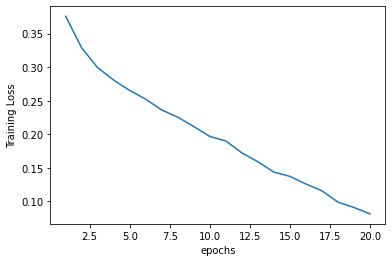

In [9]:
plt.plot(np.arange(1,epochs+1,1),train_loss)
plt.xlabel('epochs')
plt.ylabel('Training Loss')
plt.show()